# Imports and installs

In [1]:
try:
    from mai_nlp_helper_functions import *
except ImportError as e:
    raise ImportError("You don't have the mai_nlp_helper_functions.py file in the same directory as your notebook. Either add it, or copy paste the contents in this cell") from e


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import spacy
import pandas as pd
import numpy as np
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from spacy.vectors import Vectors
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import datetime

tqdm.pandas()

## Get data

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/JosPolfliet/vlerick-mai-nlp-2023/main/DATA/esg_reports.csv")
df["subject"] = df["subject"].fillna("Other")
df

,text,subject
0,"Since its inception in 2010, we have distribut...",Social
1,"I will focus first on traffic, which is a key ...",Other
2,"Also, many farms are aged with degraded soil t...",Environmental
3,"Alaska 2009 STEWARDSHIP REPORT54 cOnSERvATIOn,...",Social
4,The company’s U.S. GOM operations can be impac...,Other
...,...,...
2180,American shad are a species of concern for res...,Environmental
2181,Weyerhaeuser's policies address best practices...,Other
2182,compares recently observed trends in weather p...,Environmental
2183,"If our partners, including our licensors, suff...",Other


## Clean data

In [5]:
def embed_words(sentence):
    tokens = spacy_tokenizer(sentence)
    return nlp.vocab.vectors.get_batch(tokens)

word_embeddings = embed_words(sentence)
print(word_embeddings)
print(word_embeddings.shape)

[[-3.0683   0.8136  -0.29935 ... -2.0391  -0.9999   1.9089 ]
 [ 0.65773 -1.1594   1.1196  ... -3.4405   2.6652   0.34709]
 [-0.58242 -1.1836  -5.4627  ...  0.27391 -2.6872   5.8941 ]
 ...
 [-3.2306   0.56394 -1.4736  ... -3.6001  -5.8731   4.4398 ]
 [-2.8209  -8.4782   0.68053 ...  3.1096   3.259   -3.3527 ]
 [-2.0586   0.34812  0.84462 ... -3.4597  -2.9688   1.4875 ]]
(30, 300)


## Simple model: just average the words

In [19]:
def embed_sentence_simple(sentence):
    """
    This is the part where you can go crazy and complex to add features, change aggregation way, use PCA, ...
    """
    word_embeddings = embed_words(sentence)
    sentence_embedding = np.concatenate([word_embeddings.min(axis=0), 
                                         word_embeddings.max(axis=0), 
                                         [embed_words(sentence).shape[0], 
                                         len([token for token in nlp(sentence["text"]) if token.is_oov])]])
    # sentence_embedding = np.concatenate([word_embeddings.min(axis=0), word_embeddings.max(axis=0)])
    # sentence_embedding = word_embeddings.mean(axis=0)
    return sentence_embedding

sentence_embedding = embed_sentence_simple(sentence)
print(sentence_embedding)
print(sentence_embedding.shape)

[ -4.82840014  -9.36170006  -5.46269989  -3.45910001  -0.34751999
  -8.27120018  -1.86430001  -5.69939995  -7.04930019  -5.80170012
  -2.0638001   -2.68070006 -16.70000076  -3.8506999   -8.82870007
  -2.33649993  -3.79570007  -2.4203999   -5.01590014 -10.85299969
  -5.5447998   -5.20639992  -8.55700016  -5.23579979  -8.31499958
  -5.03270006  -6.6631999   -7.8361001   -5.7895999   -3.5453999
  -9.61009979  -1.99899995  -8.50819969  -4.41919994  -5.66230011
  -5.45609999  -4.2823      -6.86199999  -7.93139982  -1.27980006
  -5.73810005  -5.19789982  -3.82019997  -2.57220006  -6.85640001
  -2.8355999   -1.85099995  -6.39169979  -4.94500017 -11.40200043
  -6.80569983  -6.28599977  -8.76519966  -8.99979973  -8.64929962
  -2.01600003  -7.4854002   -3.93429995  -4.80100012  -7.59210014
  -9.5401001   -2.19560003  -7.50339985  -9.11750031  -0.75098997
 -15.05900002  -6.10099983  -9.94390011  -7.11609983  -0.50582999
  -5.9907999   -6.07989979  -4.93599987 -12.64700031  -5.56680012
  -1.113999

In [20]:
%%time

df["features_simple"] = df.progress_apply(embed_sentence_simple,axis=1)

# For bigger datasets, you can write the results to disk to cache them
# df.to_pickle("DATA/df_with_features.pkl")

100%|████████████████████████████████████████████████████████████████████| 2185/2185 [00:50<00:00, 43.13it/s]

CPU times: user 50 s, sys: 686 ms, total: 50.6 s
Wall time: 50.7 s


In [21]:
# Load cached results
# df = pd.read_pickle("DATA/df_with_features.pkl")

## Classify

In [22]:
X = np.stack(df["features_simple"].values)
y = np.array(df["subject"])


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22141)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")



X_train shape: (1638, 602)
X_test shape: (547, 602)
y_train shape: (1638,)
y_test shape: (547,)


In [24]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=2, random_state=22141, class_weight="balanced", n_estimators=300)
clf.fit(X_train, y_train)



CPU times: user 898 ms, sys: 5.73 ms, total: 904 ms
Wall time: 904 ms


RandomForestClassifier(class_weight='balanced', max_depth=2, n_estimators=300,
                       random_state=22141)

## Evaluate

Enter experiment name:  min, max, lensentence, first word's embedding


               precision    recall  f1-score   support

Environmental       0.77      0.53      0.63       299
        Other       0.51      0.48      0.50       115
       Social       0.37      0.66      0.48       133

     accuracy                           0.55       547
    macro avg       0.55      0.55      0.53       547
 weighted avg       0.62      0.55      0.56       547



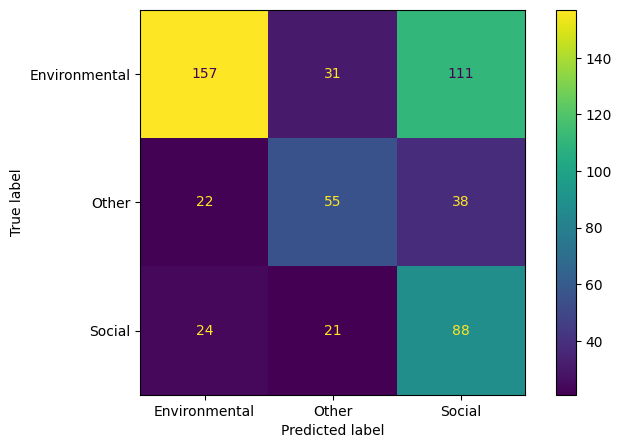

In [25]:

experiment_name = input("Enter experiment name: ")
predictions = clf.predict(X_test)
stats = evaluate_model(y_test, predictions, clf.classes_)
log_experiment_results(experiment_name, stats["macro avg"])

## What's next?

The example above is to illustrate the theory of embeddings. In reality, you can build pipelines super easily with SpaCy (if you prioritize speed) or HuggingFace transfomers (if you prioritize accuracy)

https://medium.com/@ycouble/training-and-integrating-a-custom-text-classifier-to-a-spacy-pipeline-b19e6a132487